# Introduction

Welcome to our analysis of the products on Amazon.com! In this project, we set out to identify the best options among the many search results on the site. To do this, we divided the project into two parts.

# Part A: Scrape Amazon Product Review
> In the first part of the project, we created a script to scrape the reviews for each search result in order to gather the necessary data. This allowed us to collect a large and diverse dataset to work with. By passing in different search terms, our script collected valuable information such as the star ratings, comments, and price of each product. This data was then used in the second part of the project to analyze and select the best options. [A demo video of the scraping process can be found here!](https://github.com/Johneration/Amazon-Web-Scraping-And-Product-Analysis/blob/main/web-scraper-demo-video.mp4)

# Part B: Analyze Amazon Product Review
> In the second part, we analyzed the scraped data and used various techniques to select the best products. Our goal was to identify patterns and trends in the data and use them to make informed decisions. To demostrate this, we used the script to scrape the reviews for the following search terms: guitar, keyboard piano and drum. We've also created various plots to visualize our findings.

### <font color=green>**This notebook demostrates how I created the script for Part A: Scrape Amazon Product Review**</font>

Overall, this project provides a comprehensive analysis of the products on Amazon and can be used by consumers to make confident and informed purchasing decisions.

# Import Modules & Define Functions

In [1]:
# Import the necessary packages for this project

import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as bs
import pandas as pd
from IPython.display import Video
import time
import os

In [2]:
# The html source of amazon.com cannot be accessed solely through the requests module because it is a dynamic website
# As a result, we will utilize the Selenium module to scrape the information on the website

def open_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=options)
    return driver

In [3]:
# Define a function to scrape review information from a single page

def get_data(driver):
    html = driver.page_source
    soup = bs(html, 'html.parser')
    
    reviews = soup.find('div', {'id': 'cm_cr-review_list'}).find_all('div', {'data-hook': 'review'})
    rows = []
    for i in reviews:
        name = i.find('div', {'class': 'a-section celwidget'}).find('div', {'data-hook': 'genome-widget', 'class': 'a-row a-spacing-mini'}).text
        stars = i.find('div', {'class': 'a-row'}).find('span', {'class': 'a-icon-alt'}).text
        date = i.find('span', {'data-hook': 'review-date'}).text
        comment = i.find('div', {'class': 'a-row a-spacing-small review-data'}).text
        rows.append([name, stars, date, comment])
    return rows

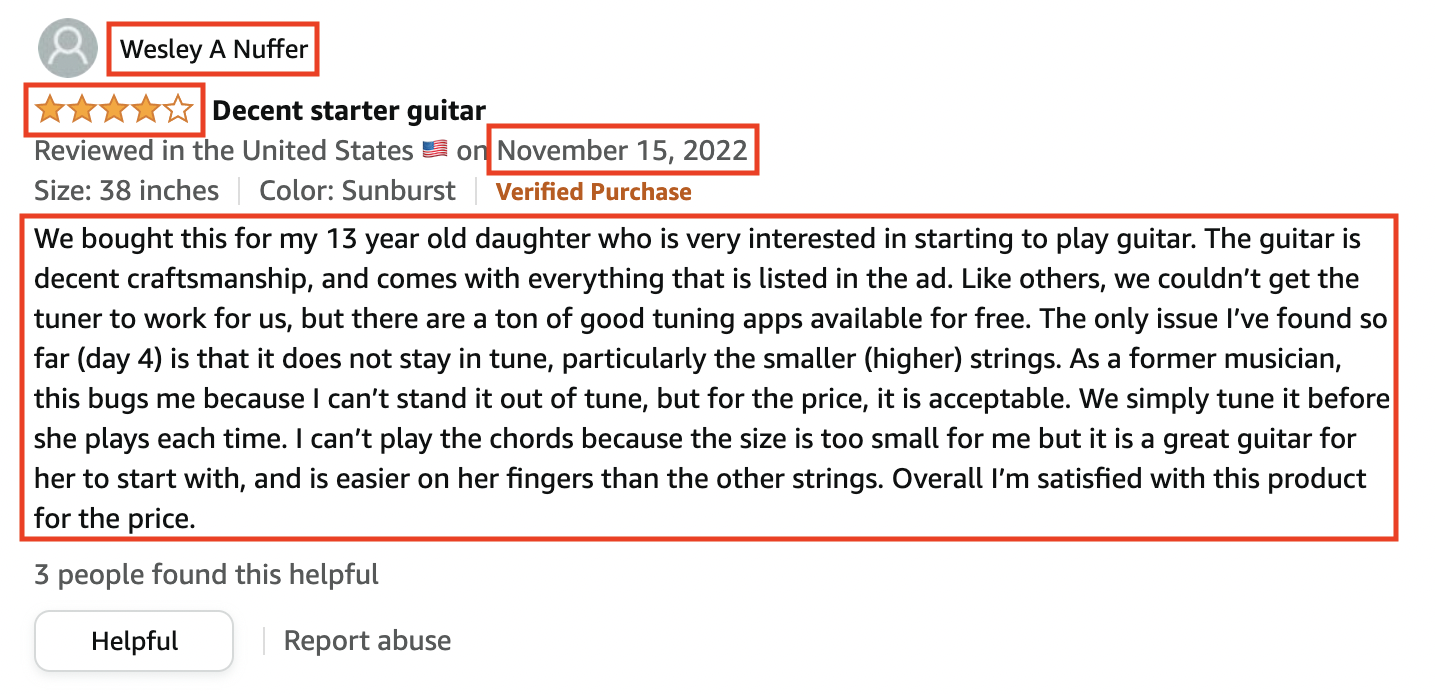

In [4]:
# Create a function that will scrape all reviews and put them in a Pandas DataFrame

def start_scraping(driver):
    rows_all = []
    
    # Scrape the reviews on the first page
    rows = get_data(driver)
    rows_all = rows_all + rows
    
    # Create a loop to click on the page button and scrape the revies until the last page is reached
    while True:
        try:
            next_page_xpath = '//*[@id="cm_cr-pagination_bar"]/ul/li[2]/a'
            driver.find_element('xpath', next_page_xpath).click()
            time.sleep(1)
            rows = get_data(driver)
            rows_all = rows_all + rows
        except:
            break           
    df = pd.DataFrame(rows_all, columns=['name', 'stars', 'date', 'comment'])
    return df

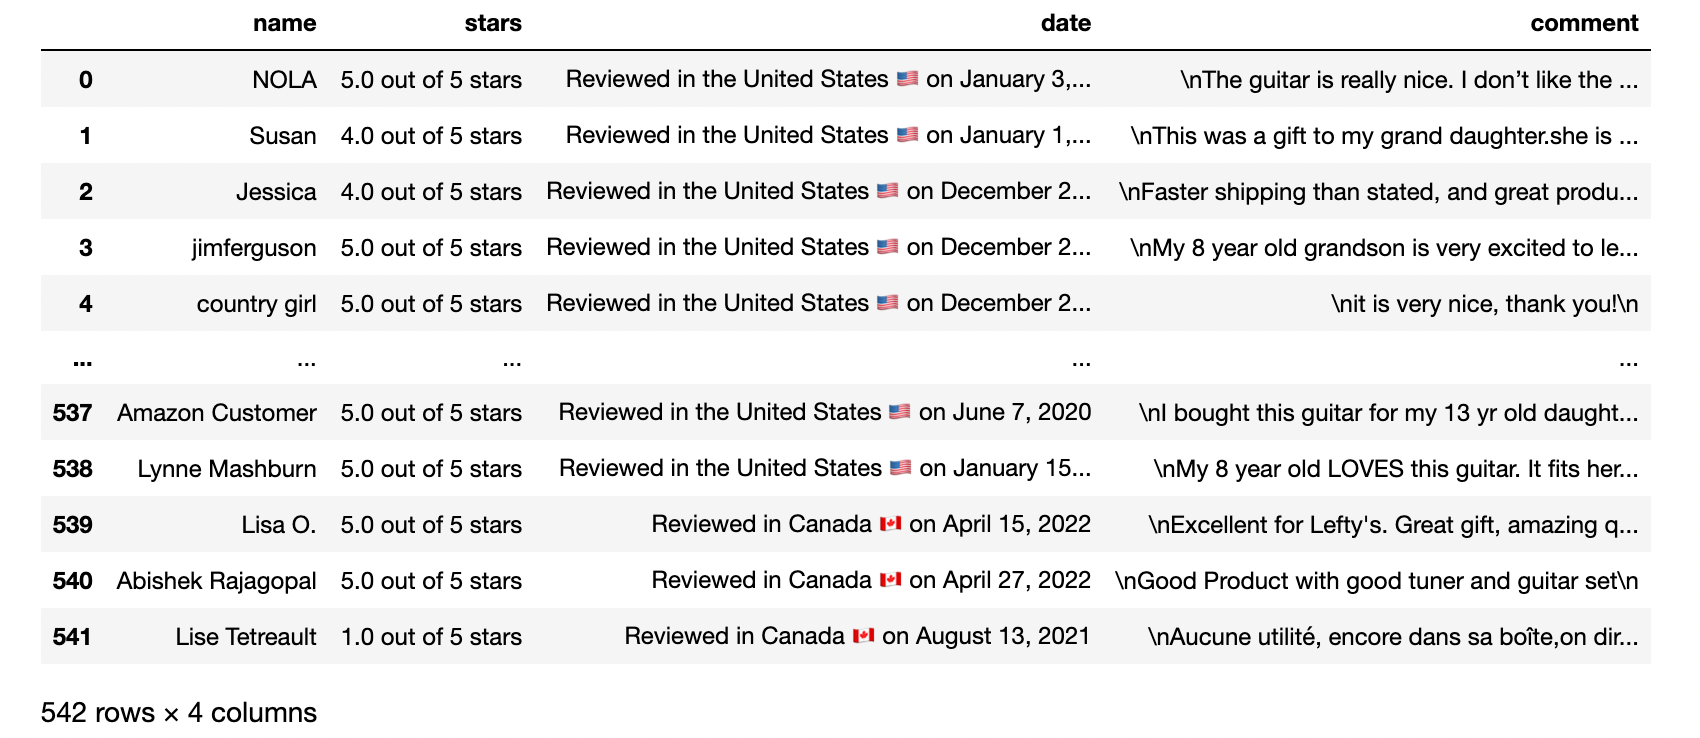

In [5]:
# Create the main function to execute the script

def main(keyword):
    url = f'https://www.amazon.com/s?k={keyword}'
    driver.get(url)
    time.sleep(1)

    html = driver.page_source
    soup = bs(html, 'html.parser')
    results = soup.find_all('div', {'data-component-type': 's-search-result'})
    
    # Get the link codes for all of the search results on the first page
    link_price = []
    for i in results:
        try:
            price = i.find('span', {'class': 'a-price-whole'}).text
        except:
            price = ''
        link = i.find('a', {'class': 'a-link-normal s-no-outline'})['href']
        if '/gp/' not in link:
            link_price.append([link, price])
            
    # Create a list to store the corresponding links and product titles
    for i in link_price:
        title = i[0].split('/')[1]
        code = i[0].split('/')[3]
        i[0] = f'https://www.amazon.com/{title}/product-reviews/{code}/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'
        i.append(title)
        i.append(code)

    # Create a list to store the DataFrames from each review page and add more information (price, keyword, title, code)
    df_ls = []
    for i in link_price:
        url = i[0]
        price = i[1] 
        title = i[2]
        code = i[3]
        driver.get(url)
        time.sleep(1)
        try:
            df = start_scraping(driver)
            df['price'] = price
            df['keyword'] = keyword
            df['title'] = title
            df['code'] = code
            df_ls.append(df)
        except:
            pass
    
    # Concatenate the DataFrames
    df_all = pd.concat(df_ls)
    df = df_all
    df.index.name = 'position'
    return df

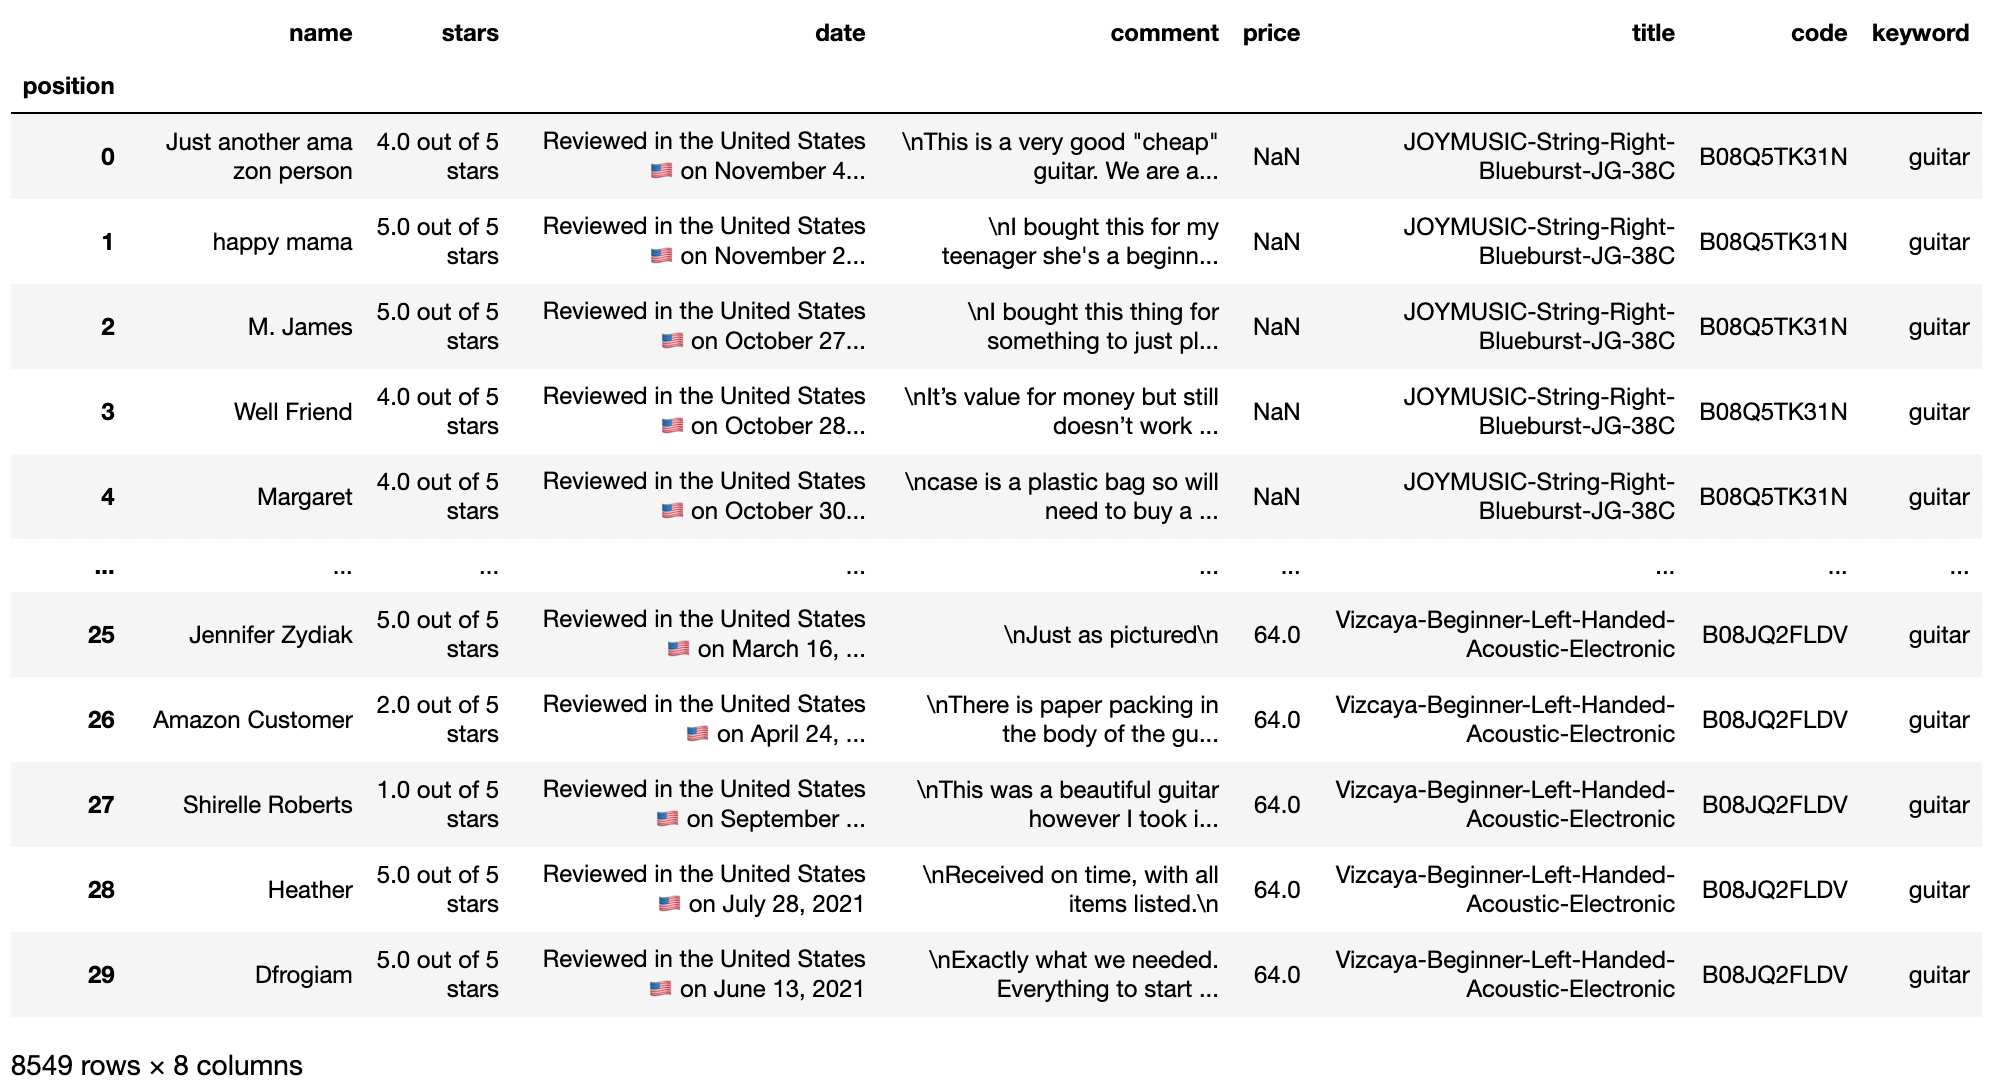

# Run The Script

In [9]:
# Activate a Google Chrome Driver

driver = open_driver()

In [8]:
# To Run the function, a keyword must be passed in as the search term for the targeted product
# In this case, we have chosen 'guitar' as the search term

df = main('guitar')